Oversampling > 2x suggested for reliable results in Fresnel propagation.


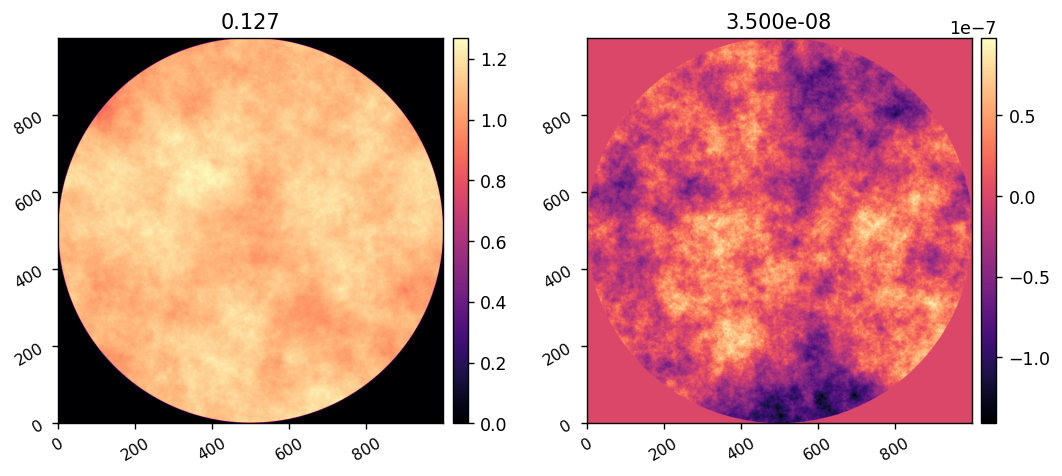

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.ad_efc as ad_efc
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*650e-9/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')


Oversampling > 2x suggested for reliable results in Fresnel propagation.


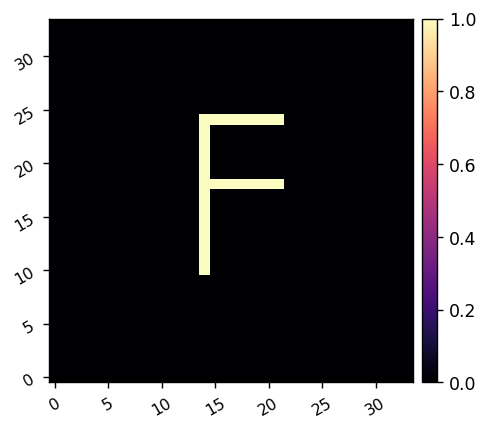

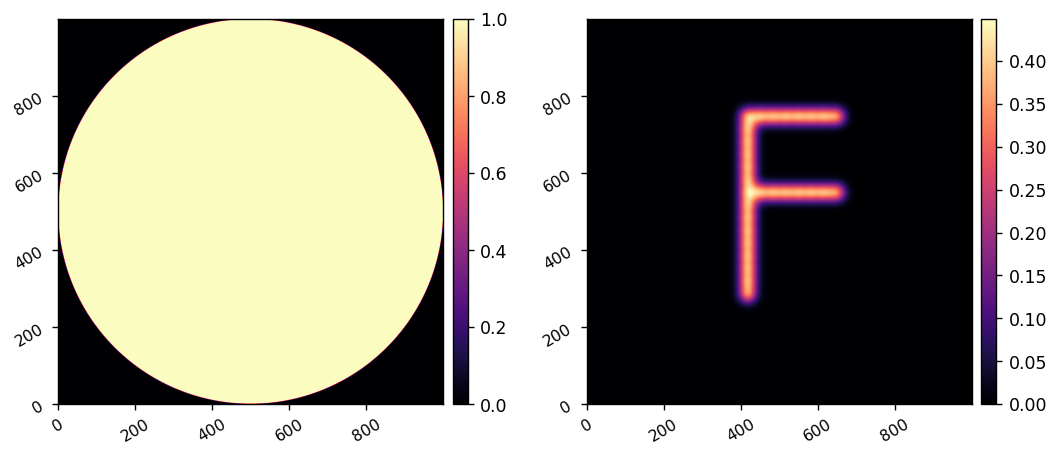

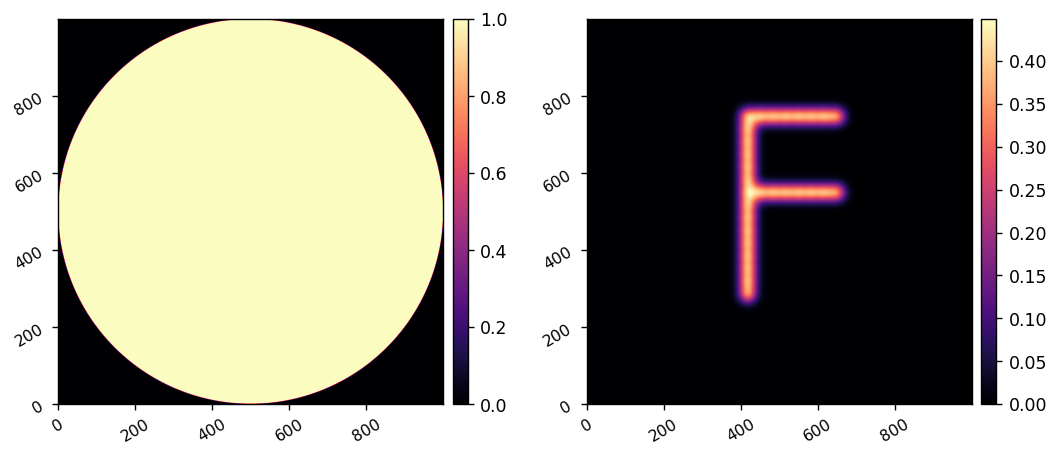

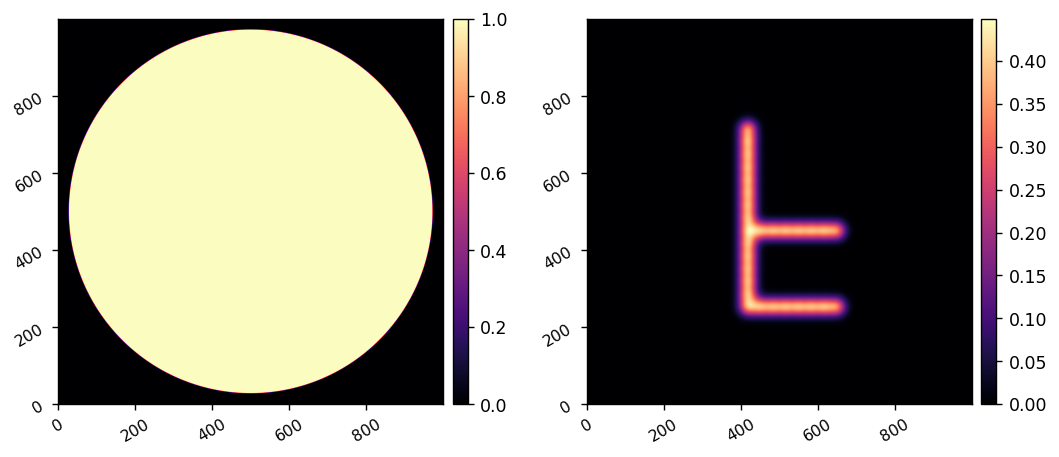

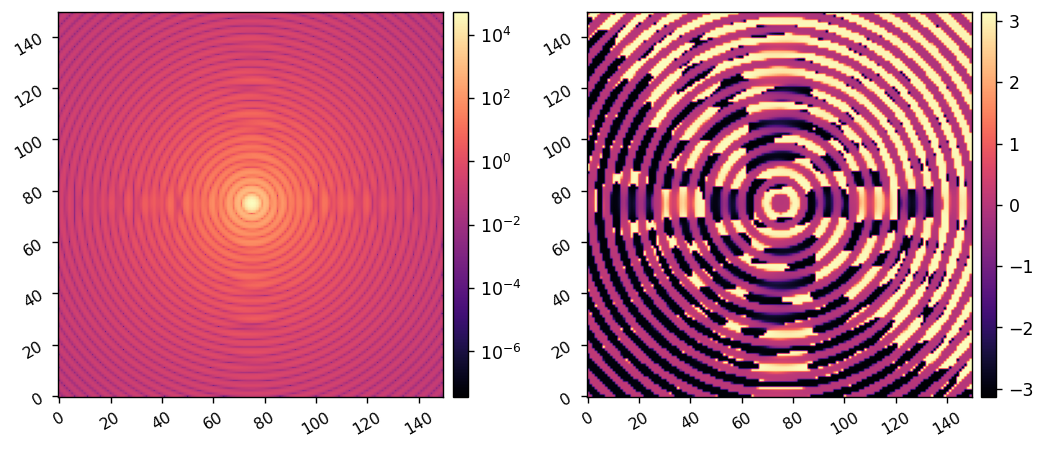

In [14]:
reload(ad_scoob)
m = ad_scoob.MODEL()
# m.WFE = WFE

acts = np.zeros(m.Nacts)

command = xp.zeros((m.Nact, m.Nact))
command[10:24,14] = 1
command[24,14:22] = 1
command[18,14:22] = 1
acts = 15e-9 * ensure_np_array(command[m.dm_mask])
imshow1(command)

fpwf = m.forward(acts, use_vortex=False, plot=True)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


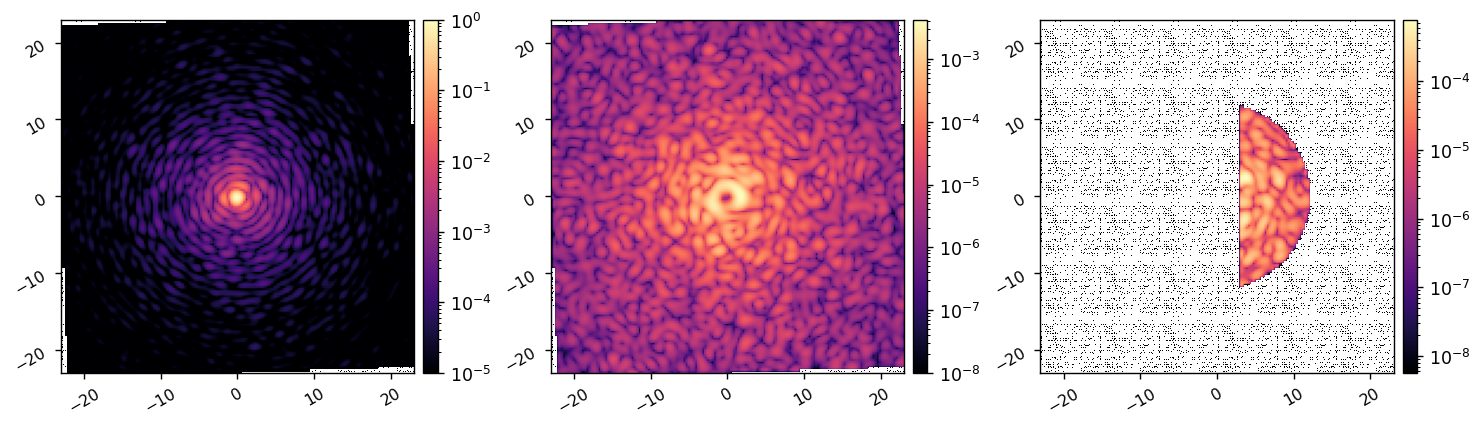

In [22]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE

# m.npsf = 150
m.det_rotation = 178
# m.psf_pixelscale_lamD = 0.307

m.create_control_mask()

acts = np.zeros(m.Nacts)

ref_psf = m.snap(acts, use_vortex=False)
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = m.snap(acts)

imshow3(ref_psf/m.Imax_ref, ref_coro_im, ref_coro_im*m.control_mask,
        pxscl=m.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-8)


0.08278704225893471 0.0 0.08278704225893471 1.0
0.0


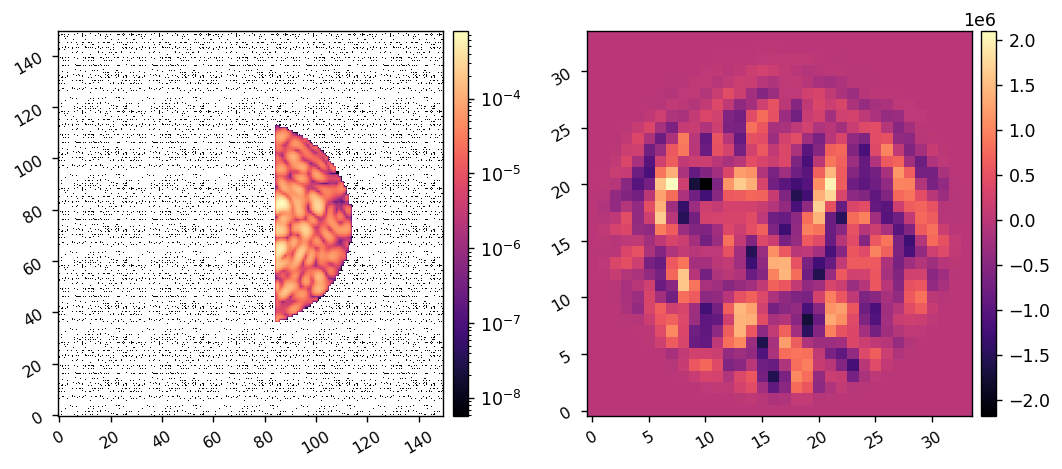

In [24]:
reload(ad_scoob)

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = m.forward(acts) * m.control_mask
r_cond = 1e-2

del_acts = np.zeros(m.Nacts)
J, dJ_dA = ad_scoob.val_and_grad(del_acts, m, acts, E_ab, r_cond, verbose=True)

dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
print(dm_grad[25,21])
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True)

In [25]:

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = m.forward(acts) * m.control_mask
r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(m.Nacts)
res = minimize(ad_scoob.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(m, acts, E_ab, r_cond, True), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


0.08278704225893471 0.0 0.08278704225893471 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.18092D+06
0.002167133679070382 2495701154.7609243 0.08278704225893471 30146035981.78126
0.0061095463308823055 24.341916969563 0.08278704225893471 294.1043169502308


 This problem is unconstrained.


0.07508286049523188 1.4833735096531135 0.08278704225893471 18.8248828273624
0.5031389785247455 0.1443922049021029 0.08278704225893471 7.821648965324211
2.4432873194019207 0.010843443472992115 0.08278704225893471 29.64389952716366
0.8406347992619851 0.0005503656436920203 0.08278704225893471 10.160831235819312
0.015502060873216346 3.0087172728384186e-05 0.08278704225893471 0.18761568987287305

At iterate    1    f=  1.87616D-01    |proj g|=  8.88463D+05
0.0059419185193051345 3.169683878389751e-05 0.08278704225893471 0.07215640509785619

At iterate    2    f=  7.21564D-02    |proj g|=  2.78805D+05
0.0029425131018291665 3.878118947166723e-05 0.08278704225893471 0.03601160531833206

At iterate    3    f=  3.60116D-02    |proj g|=  1.54064D+05
0.0018809878260188028 4.4262242461563926e-05 0.08278704225893471 0.023255451770564806

At iterate    4    f=  2.32555D-02    |proj g|=  1.18863D+05
0.0013713387558228697 5.022434936123994e-05 0.08278704225893471 0.017171323753032

At iterate    5    f=

5.091454013464619e-05 2.0521793660140711e-07
0.0


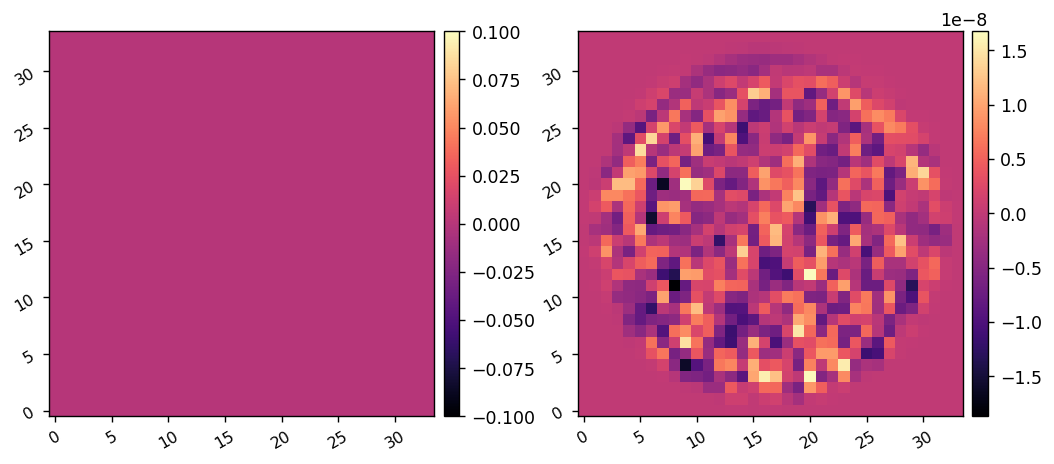

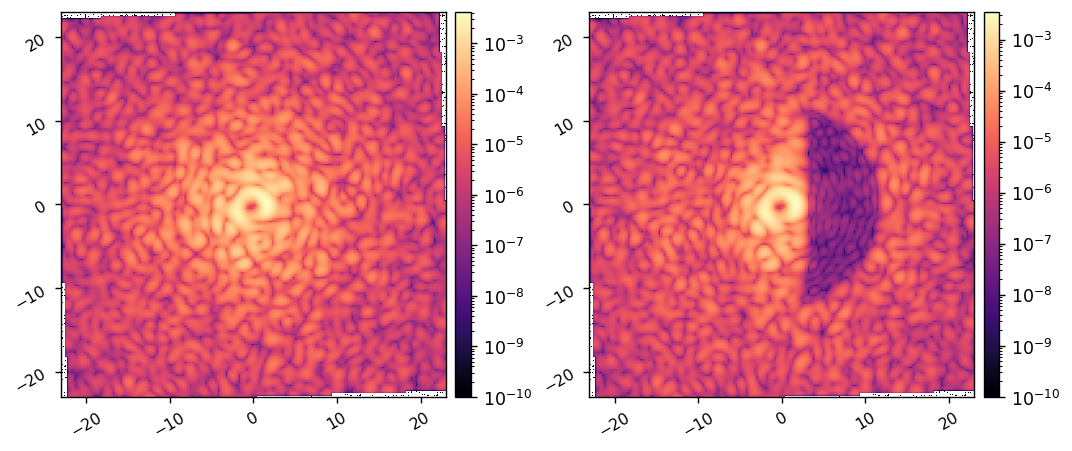

In [27]:
old_command = ad_scoob.acts_to_command(acts, m.dm_mask)
del_command = ad_scoob.acts_to_command(res.x, m.dm_mask)
old_im = m.snap(acts)
new_im = m.snap(acts + res.x)

print(xp.mean(old_im[m.control_mask]), xp.mean(new_im[m.control_mask]))
print(del_command[25,21])
imshow2(old_command, del_command)
imshow2(old_im, new_im, lognorm=True, pxscl=m.psf_pixelscale_lamD, vmin1=1e-10, vmin2=1e-10)

In [6]:
utils.save_fits('data/ad_test_acts.fits', res.x)

Saved data to:  data/ad_test_acts.fits


In [28]:
all_ims = []
all_efs = []
all_commands = []


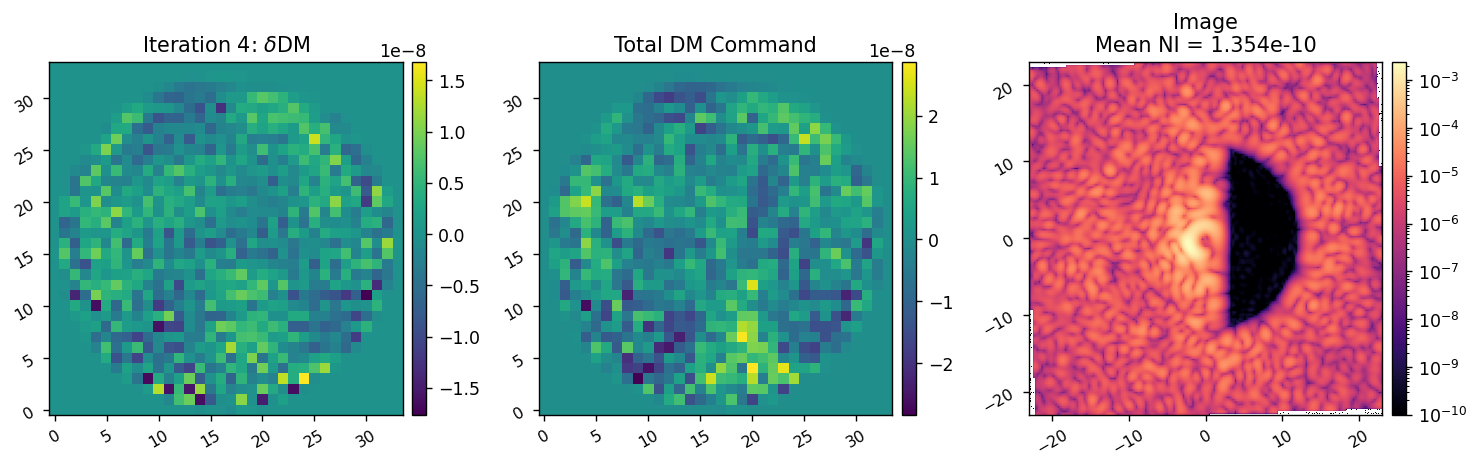

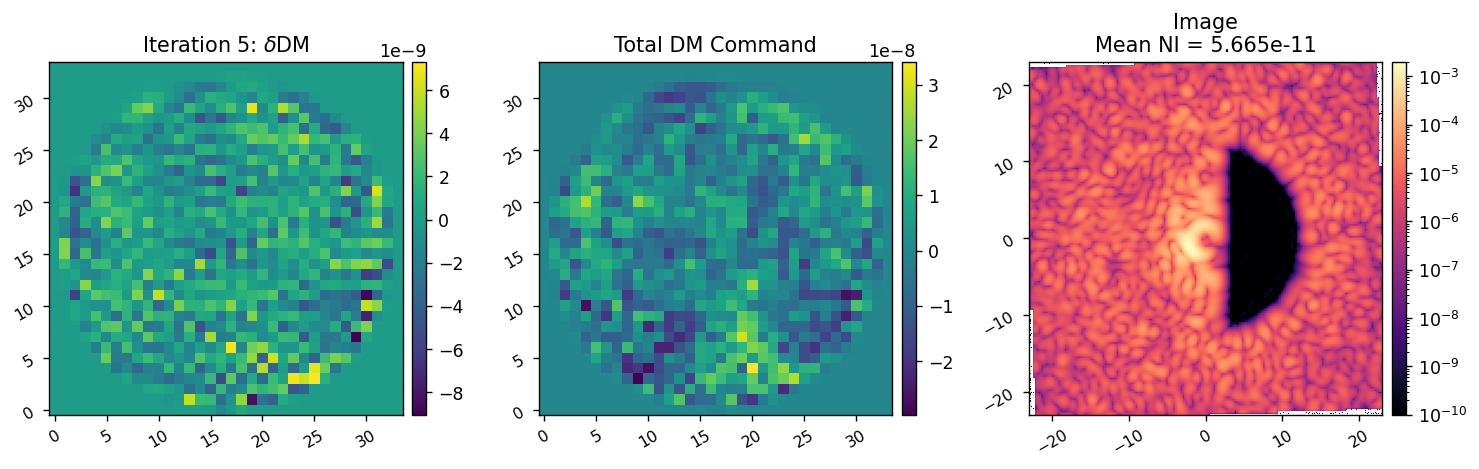

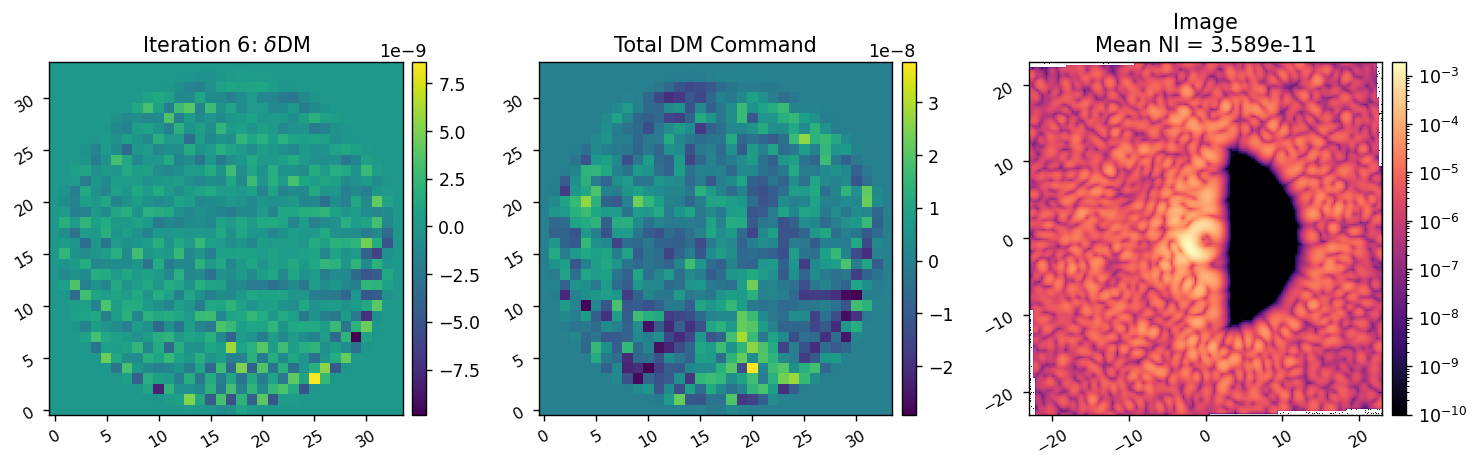

In [30]:
reload(ad_scoob)
reload(ad_efc)

r_cond = 1e-2
r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

all_ims, all_efs, all_commands = ad_efc.sim(m, ad_scoob.val_and_grad,
                                            Nitr=3, 
                                            reg_cond=r_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=1,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )